# Procedural Python for Reproducibility

The goal today is to take some of the ideas we've developed in the past few weeks, and do a couple things to make our lives easier:

- Define standalone functions which accomplish tasks that we would like to do repeatedly
- Put these functions in a place where we can easily use them without copy-pasting repeatedly
- Think about how to make our analysis reproducible – both for the sake of our future selves, and for the sake of anyone who wants to replicate and/or build on our work.

To that end, we are going to work together to do the following tasks:

1. Write a function which will download the zipped Pronto data.

   - This function should **only** download the data if it hasn't already been downloaded
   
2. Write functions which, given the zip file, will access the particular data that we would like to look at and return a pandas array.

   - These functions should **not** extract the data to disk if possible (because some files are very big when uncompressed)
   - These functions should take care of things like parsing dates, etc.
   
3. Write a function which will group and join the trip and weather data into a single DataFrame, making use of the above functions.
   
4. Develop some plots showing relationships in the data, and write a function which will create and save plots related to your analysis.

   - Number of rides per day over the course of the year (short-term vs annual members)
   - Number of rides per hour over the course of the day (short-term vs annual members)
   - Number of rides per day as a function of temperature (short-term vs annual members)
   
5. Write a master script that you – or anyone – can run, which will produce your analysis from scratch.

Today during the class time we will walk through accomplishing these tasks together.

---

The final result of what we did looks something like this (download the file: [pronto_utils.py](pronto_utils.py))

```python
"""pronto_utils.py"""

import wget
import os
import zipfile
import pandas as pd

import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot stylings


def download_if_needed(URL, filename):
    """
    Download from URL to filename unless filename already exists
    """
    if os.path.exists(filename):
        print(filename, 'already exists')
        return
    else:
        print('downloading', filename)
        wget.download(URL)


def get_pronto_data():
    """
    Download pronto data, unless already downloaded
    """
    download_if_needed('https://s3.amazonaws.com/pronto-data/open_data_year_one.zip',
                       'open_data_year_one.zip')


def get_trip_data():
    """
    Fetch pronto data (if needed) and extract trips as dataframe
    """
    get_pronto_data()
    zf = zipfile.ZipFile('open_data_year_one.zip')
    file_handle = zf.open('2015_trip_data.csv')
    return pd.read_csv(file_handle)


def get_weather_data():
    """
    Fetch pronto data (if needed) and extract weather as dataframe
    """
    get_pronto_data()
    zf = zipfile.ZipFile('open_data_year_one.zip')
    file_handle = zf.open('2015_weather_data.csv')
    return pd.read_csv(file_handle)


def get_trips_and_weather():
    trips = get_trip_data()
    weather = get_weather_data()

    # This is a nice way to access date info in a column
    date = pd.DatetimeIndex(trips['starttime'])

    # pivot table = two-dimensional groupby
    trips_by_date = trips.pivot_table('trip_id', aggfunc='count',
                                      index=date.date, columns='usertype')

    weather = weather.set_index('Date')
    weather.index = pd.DatetimeIndex(weather.index)
    weather = weather.iloc[:-1]
    return weather.join(trips_by_date)


def plot_daily_totals():
    data = get_trips_and_weather()
    fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True)
    data['Annual Member'].plot(ax=ax[0], title='Annual Member')
    data['Short-Term Pass Holder'].plot(ax=ax[1], title='Short-Term Pass Holder')
    fig.savefig('daily_totals.png')
```

With this, we can then create our daily totals plot with just a few lines of code:

open_data_year_one.zip already exists
open_data_year_one.zip already exists


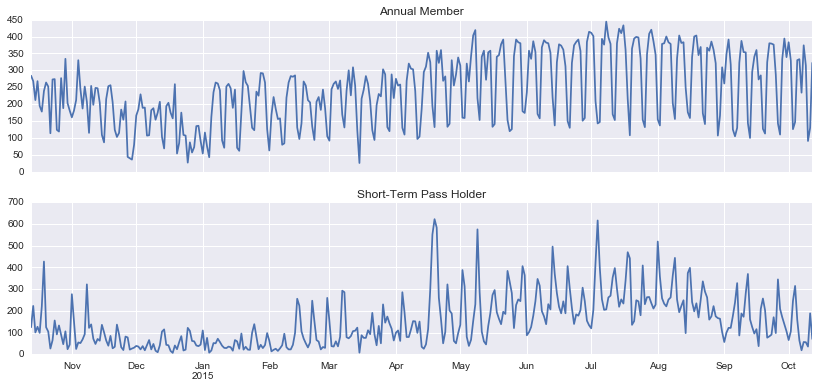

In [1]:
%matplotlib inline
from pronto_utils import plot_daily_totals
plot_daily_totals()